In [1]:
# imports and basic notebook setup
from cStringIO import StringIO
import caffe
import numpy as np
import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from google.protobuf import text_format
import scipy.io
model_path = '../caffe/models/googlenet_places205/' # substitute your path here
mean_fn = model_path + 'places_mean.binaryproto'

proto_data = open(mean_fn, 'rb' ).read()
a = caffe.proto.caffe_pb2.BlobProto.FromString(proto_data)
#from https://github.com/BVLC/caffe/issues/2075 and http://nbviewer.ipython.org/url/www.openu.ac.il/home/hassner/projects/cnn_agegender/cnn_age_gender_demo.ipynb
mean = np.array(caffe.io.blobproto_to_array(a)[0]).mean(1).mean(1)

print len(mean)

def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
net_fn   = model_path + 'deploy_places205.protxt'
param_fn = model_path + 'googlelet_places205_train_iter_2400000.caffemodel'

# Patching model to be able to compute gradients.
# Note that you can also manually add "force_backward: true" line to "deploy.prototxt".
model = caffe.io.caffe_pb2.NetParameter()
text_format.Merge(open(net_fn).read(), model)
model.force_backward = True
open('tmp.prototxt', 'w').write(str(model))

net = caffe.Classifier(model_file = 'tmp.prototxt', pretrained_file = param_fn, channel_swap = (2,1,0),
                       mean = mean) # the reference model has channels in BGR order instead of RGB

# a couple of utility functions for converting to and from Caffe's input image layout
def preprocess(net, img):
    return np.float32(np.rollaxis(img, 2)[::-1]) - net.transformer.mean['data']
def deprocess(net, img):
    return np.dstack((img + net.transformer.mean['data'])[::-1])

def make_step(net, step_size=1.5, end='inception_4c/output', jitter=32, clip=True):
    '''Basic gradient ascent step.'''

    src = net.blobs['data'] # input image is stored in Net's 'data' blob
    dst = net.blobs[end]

    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    src.data[0] = np.roll(np.roll(src.data[0], ox, -1), oy, -2) # apply jitter shift
            
    net.forward(end=end)
    dst.diff[:] = dst.data  # specify the optimization objective
    net.backward(start=end)
    g = src.diff[0]
    # apply normalized ascent step to the input image
    src.data[:] += step_size/np.abs(g).mean() * g

    src.data[0] = np.roll(np.roll(src.data[0], -ox, -1), -oy, -2) # unshift image
            
    if clip:
        bias = net.transformer.mean['data']
        src.data[:] = np.clip(src.data, -bias, 255-bias)    
        
def deepdream(net, base_img, iter_n=10, octave_n=4, octave_scale=1.4, end='inception_4c/output', clip=True, **step_params):
    # prepare base images for all octaves
    octaves = [preprocess(net, base_img)]
    for i in xrange(octave_n-1):
        octaves.append(nd.zoom(octaves[-1], (1, 1.0/octave_scale,1.0/octave_scale), order=1))
    
    src = net.blobs['data']
    detail = np.zeros_like(octaves[-1]) # allocate image for network-produced details
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        if octave > 0:
            # upscale details from the previous octave
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1.0*h/h1,1.0*w/w1), order=1)

        src.reshape(1,3,h,w) # resize the network's input image size
        src.data[0] = octave_base+detail
        for i in xrange(iter_n):
            make_step(net, end=end, clip=clip, **step_params)
            
            # visualization
            vis = deprocess(net, src.data[0])
            if not clip: # adjust image contrast if clipping is disabled
                vis = vis*(255.0/np.percentile(vis, 99.98))
            showarray(vis)
            print octave, i, end, vis.shape
            clear_output(wait=True)
            
        # extract details produced on the current octave
        detail = src.data[0]-octave_base
    # returning the resulting image
    return deprocess(net, src.data[0])

3


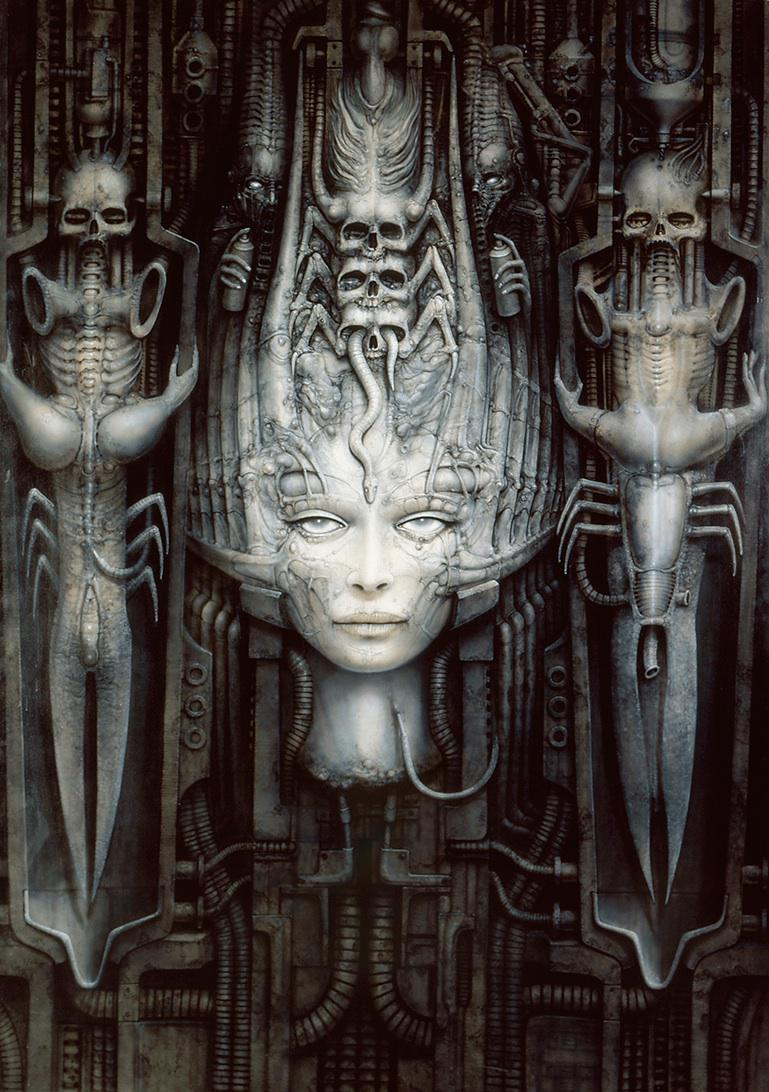

In [4]:
frame_i = 0
srcname = 'giger-li'
img = np.float32(PIL.Image.open('%s.jpg'%srcname))
showarray(img)

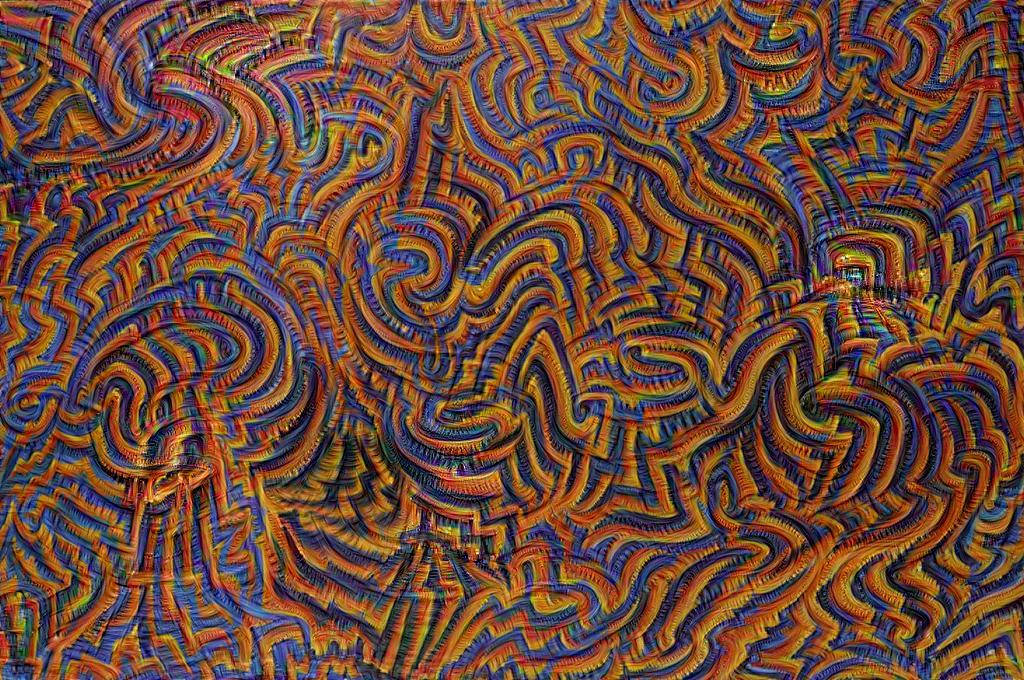

In [10]:
dreamed=deepdream(net, dreamed, end='inception_3b/5x5', iter_n=8, octave_n=5)
showarray(dreamed)

In [2]:
net.blobs.keys()

['data',
 'conv1/7x7_s2',
 'pool1/3x3_s2',
 'pool1/norm1',
 'conv2/3x3_reduce',
 'conv2/3x3',
 'conv2/norm2',
 'pool2/3x3_s2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_0',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_1',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_2',
 'pool2/3x3_s2_pool2/3x3_s2_0_split_3',
 'inception_3a/1x1',
 'inception_3a/3x3_reduce',
 'inception_3a/3x3',
 'inception_3a/5x5_reduce',
 'inception_3a/5x5',
 'inception_3a/pool',
 'inception_3a/pool_proj',
 'inception_3a/output',
 'inception_3a/output_inception_3a/output_0_split_0',
 'inception_3a/output_inception_3a/output_0_split_1',
 'inception_3a/output_inception_3a/output_0_split_2',
 'inception_3a/output_inception_3a/output_0_split_3',
 'inception_3b/1x1',
 'inception_3b/3x3_reduce',
 'inception_3b/3x3',
 'inception_3b/5x5_reduce',
 'inception_3b/5x5',
 'inception_3b/pool',
 'inception_3b/pool_proj',
 'inception_3b/output',
 'pool3/3x3_s2',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_0',
 'pool3/3x3_s2_pool3/3x3_s2_0_split_1',
 'pool3/3x3_s2_p

In [ ]:
!mkdir -p frames/orig

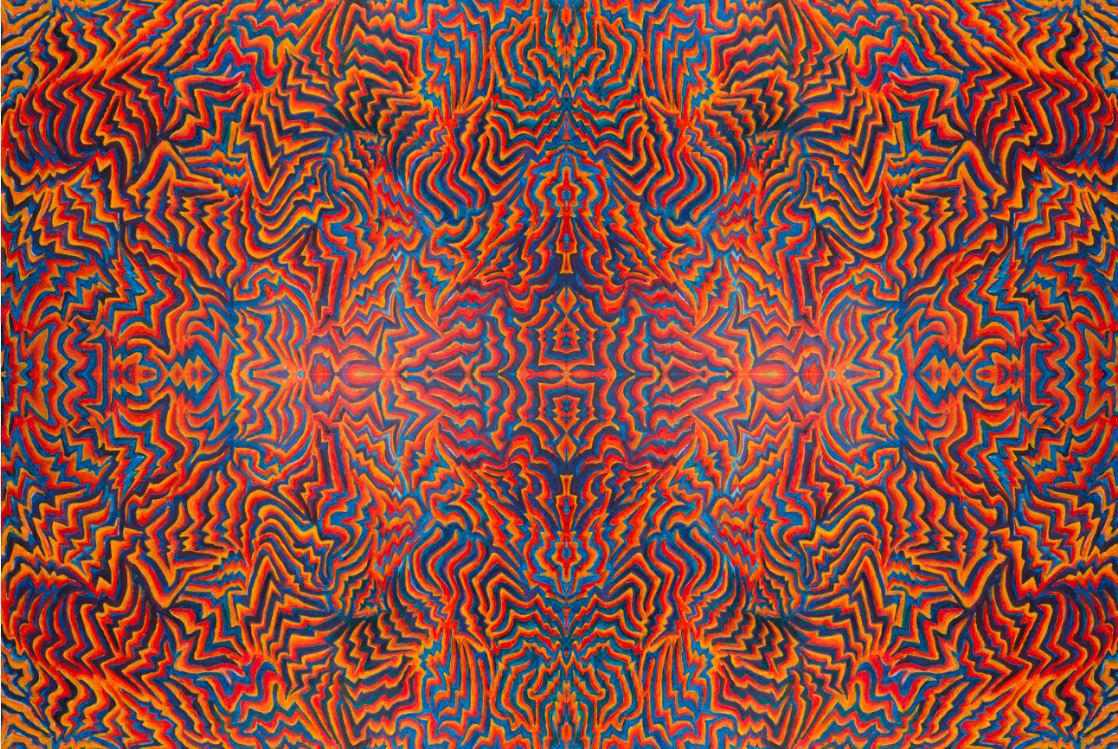

In [19]:
frame_i = 0
srcname = 'xuyzVdl'
frame = np.float32(PIL.Image.open('%s.jpg'%srcname)) #img
showarray(frame)

In [41]:
frame_i = 2
frame = img

In [7]:
print frame_i
print "frames/places/%s-%d.jpg"%(srcname, frame_i)

0
frames/places/BtQlrTR-0.jpg


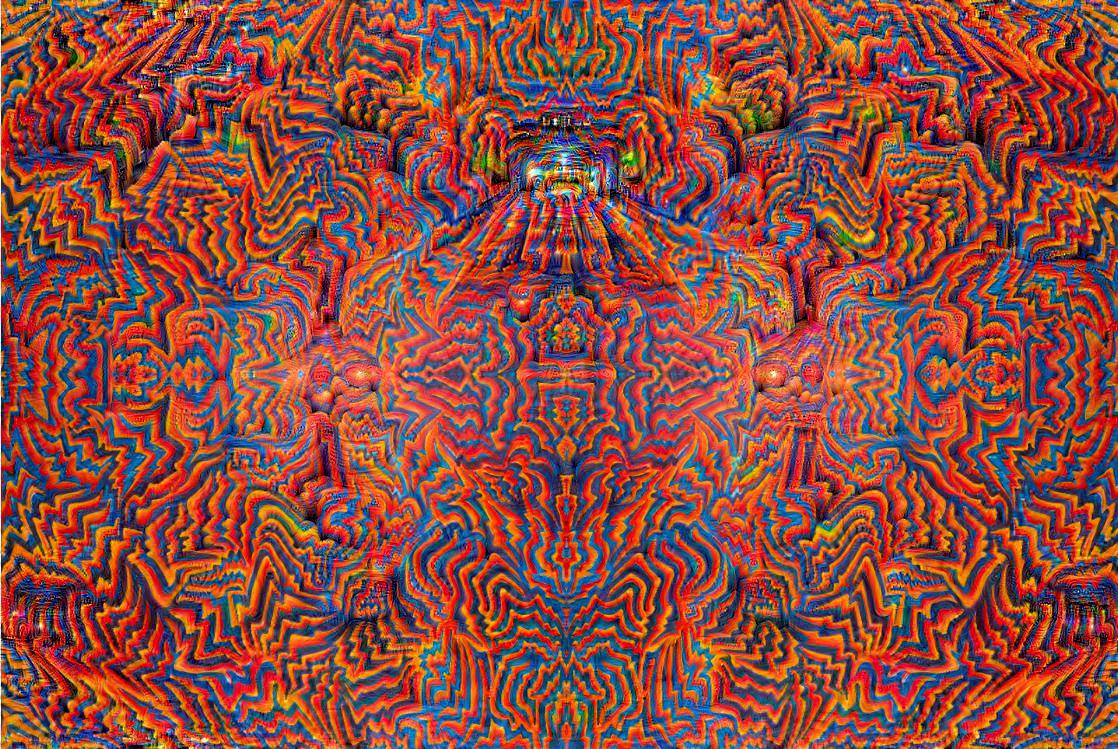

4 4 inception_5a/5x5_reduce (749, 1118, 3)


In [ ]:
h, w = frame.shape[:2]
s = 0.15 #0.5 scale coefficient
keys = net.blobs.keys()
endIdx = len(keys) - 4
idxStep = -1
for i in xrange(100):
    end="inception_5a/5x5_reduce" #keys[endIdx]
    frame = deepdream(net, frame, end=end, iter_n=8, octave_n=5)
    PIL.Image.fromarray(np.uint8(frame)).save("frames/places/%s-%d.jpg"%(srcname, frame_i))
    #frame = nd.affine_transform(frame, [1-s,1-s,1], [h*s/2,w*s/2,0], order=1)
    frame_i += 1
    #endIdx += idxStep
    

In [67]:
scale = 0.15
oldframe = frame
frame = nd.affine_transform(frame, [1-scale,1-scale,1], [h*scale/2,w*scale/2,0], order=1)

In [12]:
frame = dreamed

NameError: name 'dreamed' is not defined

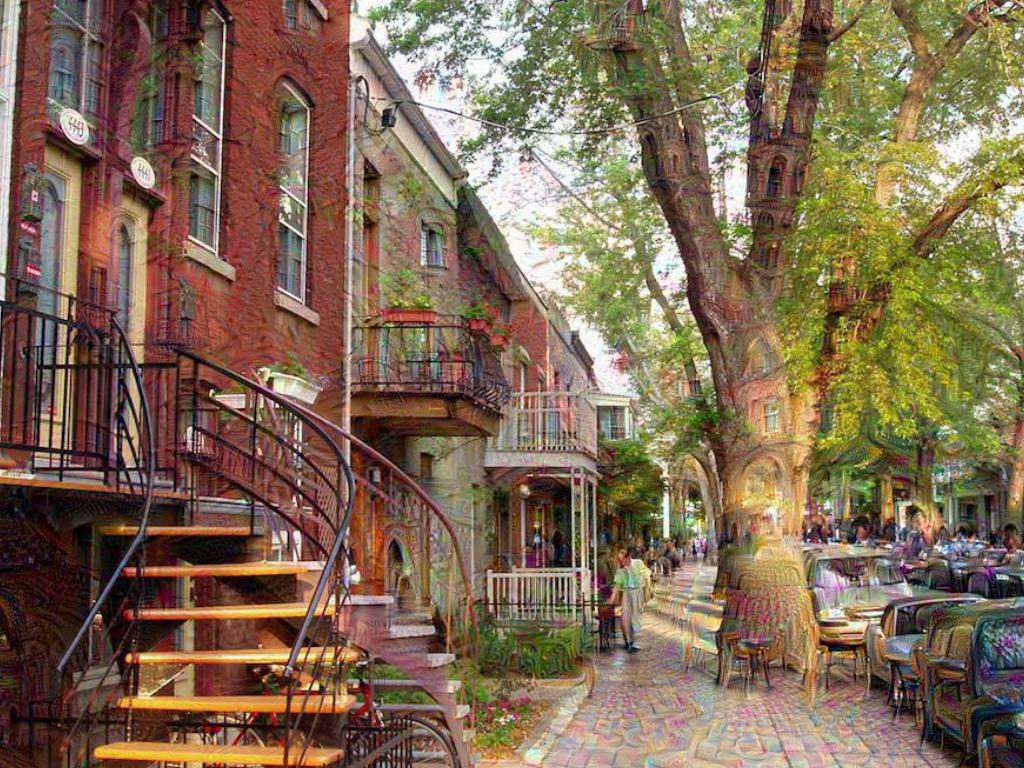

In [66]:
scale = 0.15
showarray(nd.affine_transform(frame, [1-scale,1-scale,1], [h*scale/2,w*scale/2,0], order=1))

In [14]:
showarray(dreamed)

NameError: name 'dreamed' is not defined